In [1]:
# Import necessary libraries
import torch
import numpy as np
import xgboost as xgb
from PIL import Image
import torchvision.transforms as transforms
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import cv2

SEED = 123
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


In [ ]:
# Paths and Parameters
checkpoint_path = r''  # Path to AlexNet model weights
xgb_model_path = r''

INPUT_SIZE = (256,256)
MEAN = (0.6181, 0.4643, 0.4194)
STD = (0.1927, 0.1677, 0.1617)

main_data_dir = r""
val_dir = os.path.join(main_data_dir, "val")
test_dir = os.path.join(main_data_dir, "test")

val_dataset = datasets.ImageFolder(root=val_dir)
class_names = list(val_dataset.classes)
print("Class to label mapping:", val_dataset.class_to_idx)

Class to label mapping: {'Acne': 0, 'Eczema': 1, 'Normal': 2, 'Perioral Dermatitis': 3, 'Psoriasis': 4, 'Rosacea': 5, 'Seborrheic Dermatitis': 6, 'Tinea Faciei': 7}


In [3]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Apply CLAHE on each channel independently if it's a color image
        if len(img_np.shape) == 3:
            channels = cv2.split(img_np)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            channels = [clahe.apply(channel) for channel in channels]
            img_np = cv2.merge(channels)
        else:
            # Apply CLAHE on grayscale images
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = clahe.apply(img_np)

        # Convert back to PIL Image
        img_clahe = Image.fromarray(img_np)
        return img_clahe



In [4]:
transform_val_test = transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val_test)

val_loader = DataLoader(val_dataset, shuffle=False)
test_loader = DataLoader(test_dataset,  shuffle=False)


In [5]:
import torch
import torch.nn as nn
from torchvision import models

model = models.alexnet(weights=None)  

model.classifier = nn.Sequential(
    *list(model.classifier.children())[:3]  
)

state_dict = torch.load(checkpoint_path, weights_only=True)

new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("model.", "") if k.startswith("model.") else k
    if new_key in model.state_dict().keys():
        new_state_dict[new_key] = v

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(new_state_dict, strict=False)  

for param in model.parameters():
    param.requires_grad = False


model.eval()
print(f"Loaded model from {checkpoint_path}")
print(model)

# from torchsummary import summary
# input_size = (3, 227, 227)
# summary(model, input_size=input_size, device=str(device))


Loaded model from C:\Users\Josh\Desktop\CUDA\alexnetmodel\61 with CLAHE.pth
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inpl

In [6]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(xgb_model_path)
print(f"Loaded XGBoost model from {xgb_model_path}")

Loaded XGBoost model from C:\Users\Josh\Desktop\CUDA\withpca\62 4096.json


In [ ]:
def evaluate_model(data_loader, set_name, export_txt=False):
    true_labels = []
    predicted_labels = []
    image_paths = []  # To store image file paths

    # Access the dataset from the DataLoader to get image file paths
    dataset = data_loader.dataset

    for idx, (images, labels) in enumerate(tqdm(data_loader, desc=f"Evaluating {set_name} Set")):
        images = images.to(device)
        labels = labels.cpu().numpy()

        with torch.no_grad():
            features = model(images).cpu().numpy()
        predictions = xgb_model.predict(features)

        true_labels.extend(labels)
        predicted_labels.extend(predictions)

        # Collect image file paths from the dataset
        image_paths.extend([dataset.samples[i][0] for i in range(idx, idx + 1)])

    # Calculate and print accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\n{set_name} Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    print(f"\n{set_name} Classification Report:\n")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{set_name} Confusion Matrix on Alexnet With XGBOOST')
    plt.show()

    if export_txt:
            output_file = f"{set_name}_with_xgb_predictions.txt"
            with open(output_file, "w") as file:
                file.write("Image File, True Label, Predicted Label\n")
                for img_path, true_label, pred_label in zip(image_paths, true_labels, predicted_labels):
                    true_class_name = class_names[true_label]
                    pred_class_name = class_names[pred_label]
                    file.write(f"{img_path}, {true_class_name}, {pred_class_name}\n")
            print(f"Predictions saved to {output_file}")


Evaluating Validation Set Set: 100%|██████████| 800/800 [00:20<00:00, 39.68it/s]



Validation Set Accuracy: 64.50%

Validation Set Classification Report:

                       precision    recall  f1-score   support

                 Acne       0.81      0.79      0.80       100
               Eczema       0.52      0.49      0.51       100
               Normal       0.80      0.70      0.75       100
  Perioral Dermatitis       0.69      0.70      0.70       100
            Psoriasis       0.55      0.48      0.51       100
              Rosacea       0.64      0.69      0.66       100
Seborrheic Dermatitis       0.54      0.62      0.58       100
         Tinea Faciei       0.62      0.69      0.65       100

             accuracy                           0.65       800
            macro avg       0.65      0.65      0.64       800
         weighted avg       0.65      0.65      0.64       800



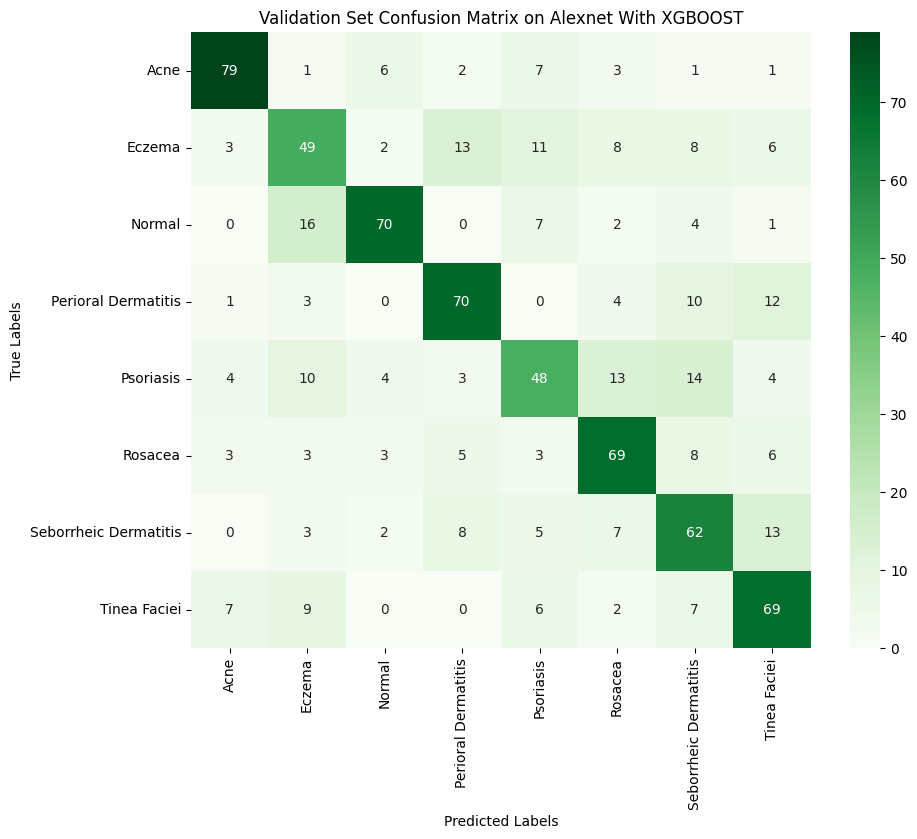

In [8]:

evaluate_model(val_loader, "Validation Set")

Evaluating Test Set Set: 100%|██████████| 400/400 [00:08<00:00, 44.79it/s]



Test Set Accuracy: 61.75%

Test Set Classification Report:

                       precision    recall  f1-score   support

                 Acne       0.72      0.78      0.75        50
               Eczema       0.53      0.38      0.44        50
               Normal       0.83      0.78      0.80        50
  Perioral Dermatitis       0.62      0.68      0.65        50
            Psoriasis       0.52      0.50      0.51        50
              Rosacea       0.56      0.70      0.62        50
Seborrheic Dermatitis       0.57      0.58      0.57        50
         Tinea Faciei       0.57      0.54      0.56        50

             accuracy                           0.62       400
            macro avg       0.62      0.62      0.61       400
         weighted avg       0.62      0.62      0.61       400



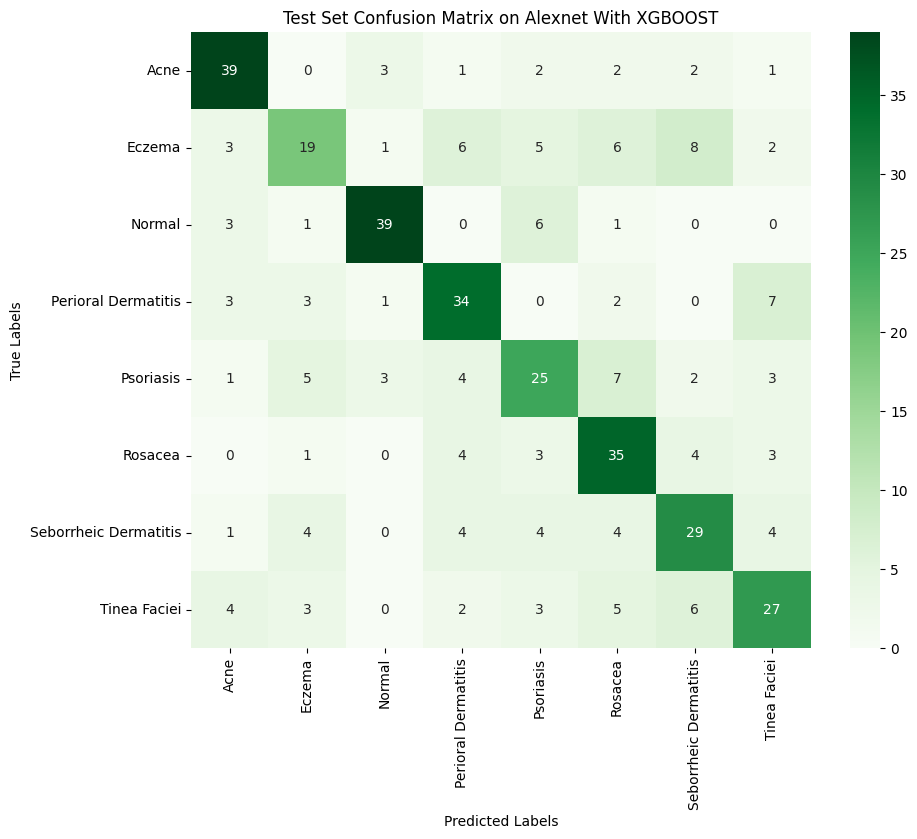

Predictions saved to Test Set_with_xgb_predictions.txt


In [11]:
evaluate_model(test_loader, "Test Set", export_txt=True)